<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.3.1'

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [5]:
import tensorflow_datasets as tfds

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [7]:
# ! pip install tensorflow-probability==0.11.0
# ! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

In [8]:
import tensorflow_probability as tfp

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking, Dropout
import tensorflow.keras.backend as K

In [10]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#### load some SDSS data


In [11]:
import sdss_pae.sdss_dataset as sdss 

In [12]:
ds, info = tfds.load('SDSS', data_dir='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data_verylarge',with_info=True, split='train')

In [13]:
info

tfds.core.DatasetInfo(
    name='sdss',
    version=1.0.0,
    description='selected features from spAll and spZbest files 
'flux': measured spectrum in  
'inv_var': inverse variance
'and_mask': and mask (set to 1 for all non-zero entries)
'coeffs': c0, c1, npix. calculate wavelengths with `10.**(c0 + c1 * np.arange(npix))`
'label': type of object, 'STAR'==0, 'QSO'==1, 'GALAXY'==2
'redshift': object redshift estimate',
    homepage='https://www.sdss.org/science/data-release-publications/',
    features=FeaturesDict({
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'filename': Text(shape=(), dtype=tf.string),
        'flux': Tensor(shape=(None, 1), dtype=tf.float32),
        'inv_var': Tensor(shape=(None, 1), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        'redshift': tf.float32,
    }),
    total_num_examples=1000000,
    splits={
        'train': 1000000,
   

In [14]:
# use only galxies for now
select_by   = [2,1]
# de-redhsift or not?
de_redshift = True

In [15]:
z_ref  = 0.1
ld_ref = cosmo.luminosity_distance(z_ref)

In [16]:
# filter dataset by redshifts and type

def filter_type_fn(x):
    if select_by is not None:
        return tf.logical_or(tf.math.equal(x['label'], select_by[0]),tf.math.equal(x['label'], select_by[1]))
    else: return 1
    
def filter_redshift_fn(x):
    if select_by is not None:
        return tf.math.logical_and(tf.math.greater(x['redshift'], 0.2),tf.math.less(x['redshift'], 0.5))
    else: return 1

ds = ds.filter(filter_type_fn)
ds = ds.filter(filter_redshift_fn)

In [17]:
DATASET_SIZE=len(list(ds))

In [18]:
print('size of subselected data:', DATASET_SIZE)

size of subselected data: 190525


In [19]:
# computing maximum and minimum redhsift in the data sample, getting distribution of data sizes
# this doe not need to be run every time - especially if wavelength range is set by user

ii          = 0
min_wl      = 100
max_wl      = -100
num_npixs   = []
img_coeffs1 = []
img_coeffs2 = []
factors     = []
min_z       = 5
max_z       = -5
redshifts   = []

for image in tfds.as_numpy(ds):
    log10wl = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    if de_redshift:
        log10wl = log10wl-np.log10(1+image['redshift'])
    if max(log10wl)>max_wl:
        max_wl= max(log10wl)
    if min(log10wl)<min_wl:
        min_wl=min(log10wl)
    redshifts.append(image['redshift'])
#     if image['redshift']>max_z:
#         max_z = image['redshift']
#     if image['redshift']<min_z:
#         min_z = image['redshift']
#     if image['coeffs'][2] not in num_npixs:
#         num_npixs.append(image['coeffs'][2][0])
#         img_coeffs1.append(image['coeffs'][1][0])
#     if image['coeffs'][0] not in img_coeffs2:
#         img_coeffs2.append(image['coeffs'][0][0])
#     if ii<10:
#         print(image['redshift'], image['label'],image['redshift'])
#         factor = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
#         plt.plot(10**log10wl,image['flux'][:,0]*10**log10wl*factor)
#         plt.show()
#         ii+=1
     
wl_range = (min_wl, max_wl) 



In [20]:
print(10**min_wl, 10**max_wl)

# compute number of pixels that span entire wl range:
npix_max = -(min_wl-max_wl)/np.unique(1e-4)
print(npix_max)

2362.9584086698555 8670.421129163975
[5645.84114495]


In [21]:
# user defined span (following Yip et al and Portillo et al)
wlmin, wlmax  = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))

In [22]:
from scipy.interpolate import interp1d

In [23]:
# new binning 
fixed_num_bins = 500
new_wl         = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

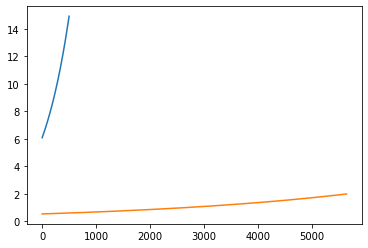

In [24]:
plt.plot(np.diff(new_wl))
plt.plot(np.diff(10**(min_wl+np.arange(npix_max)*1e-4)))

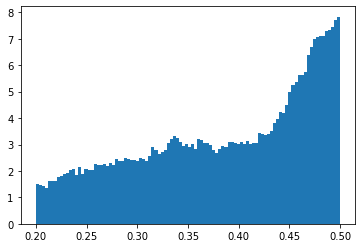

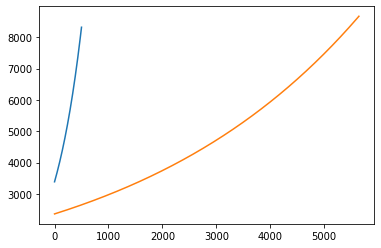

In [25]:
_ = plt.hist(np.asarray(redshifts), bins=100,density=True)
plt.show()

plt.plot((new_wl))
plt.plot((10**(min_wl+np.arange(npix_max)*1e-4)))
plt.show()

In [26]:
max(redshifts)

0.49999976

In [27]:
from scipy.stats import binned_statistic

In [28]:
raw_flux           = []
raw_noise          = []
raw_masks          = []

res_fluxes         = []
res_inv_vars       = []
res_masks          = []
redshifts          = []

SNs                = []

flag               = []

ii=0

for nn, image in enumerate(tfds.as_numpy(ds)):
        
    # compute wavelengths
    log10wl  = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    log10wl  = log10wl
    wl       = 10**log10wl
    

    ##rescale flux by wavelength and distance
    factor   = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
    #flux
    
    ### change that to before de-redshifting
    flux     = image['flux'][:,0]*factor*wl
    #inv_var
    inv_var  = image['inv_var'][:,0]/(wl*factor)**2
    
    #de-redshift
    wl/=(1.+image['redshift'])
    
    #mask
    mask           = np.squeeze(image['and_mask'])
    #mask pixels that are completely noise dominated (mask!)
    noise_         = np.squeeze(inv_var)
    ind            = np.where(noise_==0.)
    mask[ind]      = False 
    mask_ind = np.where(mask)

    if len(mask_ind[0])==0:
        continue

    else:
        res_flux, _, _ = binned_statistic(wl[mask_ind], flux[mask_ind],bins=new_wl)

        noise          = 1./noise_[mask_ind]
        noise_, _, _   = binned_statistic(wl[mask_ind],noise,bins=new_wl)
        N, _, _        = binned_statistic(wl[mask_ind],values=np.zeros(len(wl[mask_ind])),statistic='count',bins=new_wl)
        new_mask_ind   = np.where(N==0)
        noise_         = noise_/N
        inv_var_res    = 1./noise_
        res_flux[new_mask_ind] = 0
        
    
#         #mask
#         # conservative
#         mask[np.where(wl<min(new_wl))]=0
#         mask[np.where(wl>max(new_wl))]=0


#         mask_ind      = np.unique(np.digitize(wl[interval[0]:interval[1]][np.where(np.logical_not(mask[interval[0]:interval[1]]))],new_wl))
#         #print(mask_ind)
        new_mask_cons = np.ones(len(new_wl)-1)
        new_mask_cons[new_mask_ind] = 0.
#         # set mask to zero outside of wl boundaries
#         new_mask_cons[np.where(new_wl<min(wl))]=0
#         new_mask_cons[np.where(new_wl>max(wl))]=0

# #         plt.plot(wl,mask)
# #         plt.plot(new_wl,new_mask_cons)
# #         plt.xlim(5000,5100)
# #         plt.show()

#         #flag is a good flag
            
        
        non_masked_index = (new_mask_cons==1)
        SN = np.sum(res_flux[non_masked_index])/np.sqrt(np.sum(1./inv_var_res[non_masked_index]))
        inv_var_res[new_mask_ind] = 0
        
        if SN>50:
            res_fluxes.append(res_flux)
            res_masks.append(new_mask_cons)
            SNs.append(SN)
            res_inv_vars.append(inv_var_res)
            redshifts.append(image['redshift'])
            
            raw_flux.append(image['flux'])
            raw_noise.append(image['inv_var'])
            raw_masks.append(image['and_mask'])
        
        
        ii+=1

In [29]:
SNs=np.asarray(SNs)

In [30]:
SNs

array([106.99383219,  70.42426269, 205.15542921, ...,  92.94040798,
       242.8499052 ,  96.71780724])

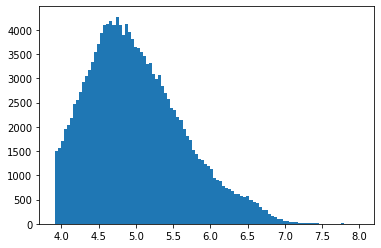

In [31]:
_ = plt.hist(np.log(SNs[np.where(SNs>0)]),bins=100)

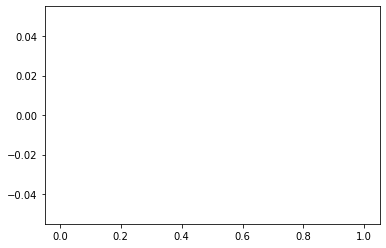

In [32]:
# before removing SNs<0
_ = plt.hist(np.log(-SNs[np.where(SNs<0)]),bins=100)


In [33]:
len(np.where(SNs<0)[0])/len(SNs)

0.0

In [34]:
# for ii in range(30):
# #     if ii in flag:
#     print(redshifts[ii])
#     #plt.plot(np.arange(1000),new_fluxes[ii])
#     print(len(res_fluxes[ii]))
#     plt.errorbar(new_wl[:-1],res_fluxes[ii])#,yerr=np.sqrt(1./res_inv_vars[ii])*res_masks[ii],ecolor='red')
#     print(np.where(np.isnan(res_fluxes[ii])))
# #     print(np.where(res_masks[ii]==0))
#     plt.errorbar(new_wl[:-1],res_fluxes[ii]*res_masks[ii])
#     #plt.ylim(-0.5,.5)
#     plt.show()
#     plt.errorbar(new_wl[:-1],res_fluxes[ii]**2*res_inv_vars[ii]*res_masks[ii])
#     #plt.ylim(-0.5,.5)
#     plt.show()

In [35]:
len(SNs)

156705

In [36]:
import sklearn

In [37]:
latent_dim = 20
dim        = fixed_num_bins

In [38]:
network_type='fully_connected'

In [39]:
from tensorflow.keras.layers import concatenate as concat

In [58]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask


input        = Input(shape=(dim,1))
input_params = Input(shape=(1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))


if network_type=='fully_connected':
# simplest, not many architectural choices other than number of neurons, likely to overfit
    #encoder_input = input#tf.concat([input,tf.tile(input_z,[tf.shape(input)[0],1])], axis=1)
#    x = Reshape((dim,))(input)
#    x = tf.concat([input,input_params],axis=1)
    x = Flatten()(input)
#     x = Dense(384)(x)
#     x = BatchNormalization()(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(latent_dim)(x)  
    #x = tf.concat([x,input_params],axis=1)
    #z = Flatten()(input_params)
    #x = tf.concat([input_params,x], axis=1)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     x = Dense(384)(x)
#     x = BatchNormalization()(x)
    x = Dense(dim)(x)
    x = Reshape((dim,1))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(256, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(256, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=64,kernel_size=(5), strides=2, name='conv1', padding='same')(input)
    x = BatchNormalization(name='bn1')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2, name='maxpool1', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2,name='conv2', padding='same')(x)
    x = BatchNormalization(name='bn2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2,name='maxpool2', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2, name='conv3', padding='same')(x)
    x = BatchNormalization(name='bn3')(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    #x = tf.concat([y,input_params],axis=1)
    x = Dense(latent_dim, name='fc_enc')(x)
    x = LeakyReLU()(x)
    #x = tf.concat([z,input_params], axis=1)
    x = Dense(1024,name='fc_dec')(x)
    x = LeakyReLU()(x)
    x = Reshape((32,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv1T', padding='same')
    x = BatchNormalization(name='bn1T')(x)
    x = LeakyReLU()(x)
    #x = UpSampling1D(2, name='up1')(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv2T', padding='same')
    x = BatchNormalization(name='bn2T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2,name='up2')(x)
    x = Conv1DTranspose(input_tensor=x,filters=64,kernel_size=(5),strides=2, name='conv3T', padding='same')
    x = BatchNormalization(name='bn3T')(x)
    x = LeakyReLU()(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
#    x = Reshape((dim,1))(x)
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = (tf.reduce_mean(loss*mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(input_data[0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}



def custom_metric(y_true, y_pred):
    loss = tf.math.square(y_true[0]-y_pred)*y_true[3]
    valid_loss = tf.reduce_mean(loss*tf.boolean_mask(loss,y_true[2]))
    return valid_loss
    
    
    
lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_params], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=['mse'],run_eagerly=False)

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 500, 1)]     0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 500)          0           input_9[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 128)          64128       flatten_2[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 128)          512         dense_20[0][0]                   
_____________________________________________________________________________________

In [59]:
# for i, l in enumerate(lstm_ae.layers):
#     print(f'layer {i}: {l}')
#     print(f'has input mask: {l.input_mask}')
#     print(f'has output mask: {l.output_mask}')

In [60]:


train_size   = int(0.6 * DATASET_SIZE)
test_size    = int(0.2 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)

# train_dataset = prep_data.take(train_size).repeat().map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),x['flux'])).batch(BATCH_SIZE)
# test_dataset  = prep_data.skip(train_size).take(test_size).map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)
# valid_dataset = prep_data.skip(train_size+test_size).take(valid_size).map(lambda x:((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)


In [61]:
def scheduler(epoch, lr):
    if epoch < 0:
        return lr
    else:
        return lr * tf.math.exp(-3.)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [62]:
train_data   = np.expand_dims(np.asarray(res_fluxes)[:train_size],-1)#/np.std(np.asarray(res_fluxes)[:60000],axis=0)
valid_data   = np.expand_dims(np.asarray(res_fluxes)[train_size:train_size+valid_size],-1)#/np.std(np.asarray(res_fluxes)[60000:],axis=0)
train_mask   = np.expand_dims(np.asarray(res_masks)[:train_size],-1)
valid_mask   = np.expand_dims(np.asarray(res_masks)[train_size:train_size+valid_size],-1)
train_noise  = np.expand_dims(np.asarray(res_inv_vars)[:train_size],-1)
valid_noise  = np.expand_dims(np.asarray(res_inv_vars)[train_size:train_size+valid_size],-1)
train_params = np.asarray(redshifts)[:train_size]
valid_params = np.asarray(redshifts)[train_size:train_size+valid_size]

In [63]:
valid_SNs = np.asarray(SNs)[train_size:train_size+valid_size]

In [66]:
BATCH_SIZE   = 128

In [ ]:
history = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_params), y=None, batch_size=BATCH_SIZE, epochs=10, callbacks=[callback])

Epoch 1/10
894/894 [==============================] - 3s 3ms/step - training_loss: 518.3242
Epoch 2/10
894/894 [==============================] - 3s 3ms/step - training_loss: 518.1426
Epoch 3/10
894/894 [==============================] - 3s 3ms/step - training_loss: 518.0973
Epoch 4/10
894/894 [==============================] - 3s 3ms/step - training_loss: 518.8510
Epoch 5/10
894/894 [==============================] - 3s 3ms/step - training_loss: 518.7612
Epoch 6/10
354/894 [==========>...................] - ETA: 1s - training_loss: 518.6050

In [406]:
history.history['training_loss']

[94541963264.0,
 111893880832.0,
 71647830016.0,
 101317894144.0,
 90634002432.0,
 102539804672.0,
 80333905920.0,
 87223427072.0,
 77275832320.0,
 72135041024.0]

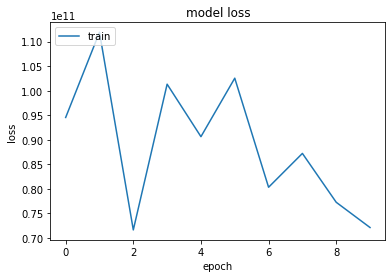

In [407]:
plt.plot(history.history['training_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [408]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(curr_layer)
        new_model.add(curr_layer)
    return new_model

In [409]:
encoder = extract_layers(lstm_ae,1,14)

decoder = extract_layers(lstm_ae,14,26)

In [410]:
encoder.build((None,fixed_num_bins))
decoder.build((None,latent_dim))

In [411]:
encoder.summary()
decoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 500)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 384)               192384    
_________________________________________________________________
batch_normalization_94 (Batc (None, 384)               1536      
_________________________________________________________________
dense_121 (Dense)            (None, 256)               98560     
_________________________________________________________________
batch_normalization_95 (Batc (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 128)             

In [412]:
encoded = encoder.predict(valid_data)

In [413]:
decoded = decoder.predict(encoded)
recon_train   = decoded

0.28480068


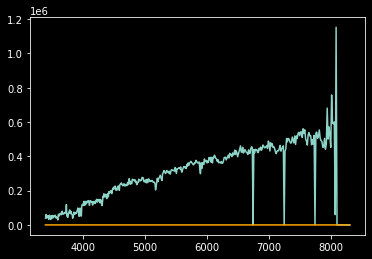

0.29703388


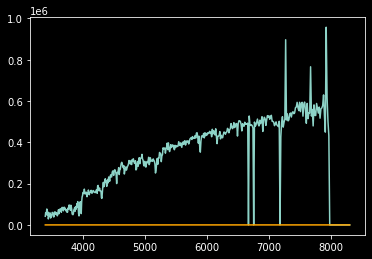

0.043669228


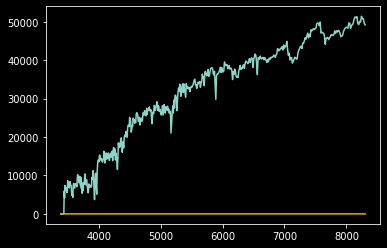

0.22446898


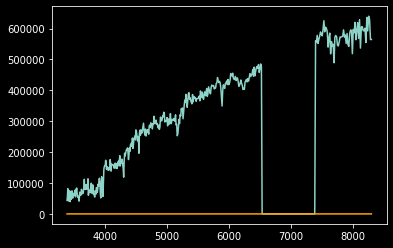

0.17243907


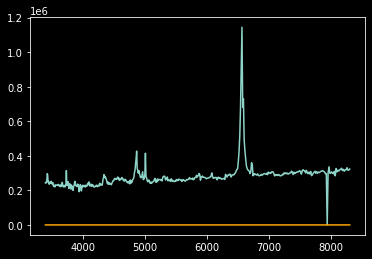

In [414]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            for ii in range(5):
                print(valid_params[ii])
                plt.plot(new_wl[:-1], np.squeeze(valid_data)[ii]*np.squeeze(valid_mask)[ii], )
                plt.plot(new_wl[:-1], np.squeeze(recon_train)[ii]*np.squeeze(valid_mask)[ii], color='orange')
                plt.show()

In [229]:
encoded

array([[-2.02039242e+00,  5.78604639e-01, -2.05166841e+00, ...,
         6.38838768e-01, -1.37557244e+00, -2.78691342e-03],
       [-1.11728907e+00, -1.90172508e-01, -1.50693178e+00, ...,
        -9.75147963e-01, -4.08469319e-01, -3.66525576e-02],
       [ 1.95714891e-01, -1.19751744e-01, -3.03623319e-01, ...,
         8.46253753e-01,  1.00608200e-01, -7.96838641e-01],
       ...,
       [ 1.17929056e-01,  3.96240443e-01, -9.98177171e-01, ...,
         1.65425444e+00,  7.03488946e-01, -3.23350608e-01],
       [-3.39309168e+00, -9.99231577e-01, -8.11563790e-01, ...,
         6.26742721e-01, -1.94501817e+00, -7.08751321e-01],
       [-1.66719878e+00, -5.71460545e-01,  2.28430241e-01, ...,
        -3.74105349e-02, -7.70365298e-01,  7.24321246e-01]], dtype=float32)

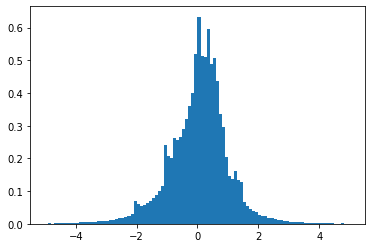

In [230]:
_=plt.hist(encoded.flatten(),bins=100,density=True, range=(-5,5))

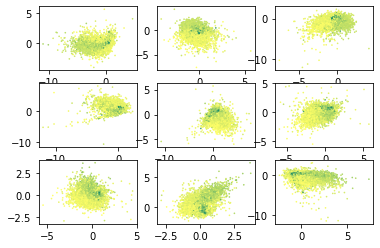

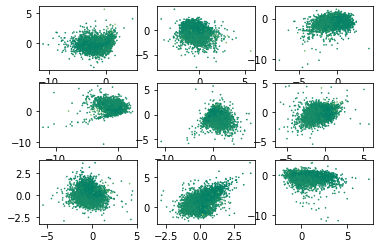

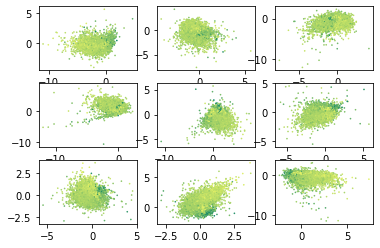

In [234]:

for ii in range(9):
    plt.subplot(3,3,ii+1)
    plt.scatter(encoded[:,ii], encoded[:,ii+1], c=valid_params, cmap=plt.cm.summer,s=0.4)
plt.show()

for ii in range(9):
    plt.subplot(3,3,ii+1)
    plt.scatter(encoded[:,ii], encoded[:,ii+1], c=np.sum(np.squeeze((valid_mask==0)),axis=1), cmap=plt.cm.summer,s=0.4)
plt.show()

for ii in range(9):
    plt.subplot(3,3,ii+1)
    plt.scatter(encoded[:,ii], encoded[:,ii+1], c=np.log(valid_SNs+1), cmap=plt.cm.summer,s=0.4)
plt.show()

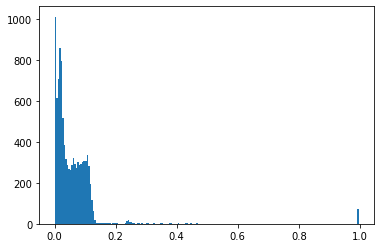

In [235]:
#masked fraction
_ = plt.hist(np.sum(np.squeeze((valid_mask==0))/1000,axis=1),bins=200)

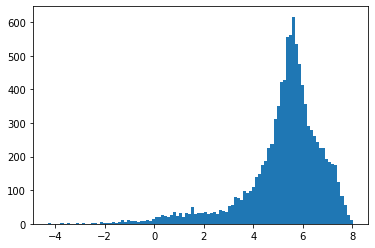

In [238]:
_ = plt.hist(np.log(valid_SNs),bins=100)

In [239]:
#! pip install --user umap-learn
import umap

In [240]:
reducer = umap.UMAP()

In [241]:
embedding = reducer.fit_transform(encoded)

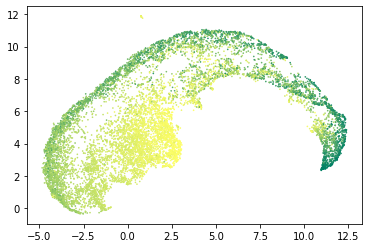

In [242]:
plt.scatter(embedding[:,0],embedding[:,1], c=valid_params, cmap=plt.cm.summer,s=0.4)

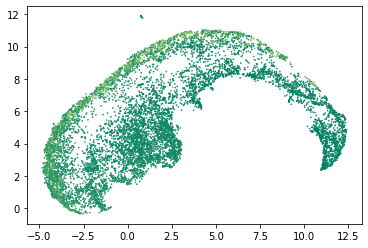

In [243]:
plt.scatter(embedding[:,0],embedding[:,1], c=valid_SNs, cmap=plt.cm.summer,s=0.4)

In [244]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

params = {'bandwidth': np.logspace(-2, 1, 25)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(encoded[:15000])

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.01      ,  0.01333521,  0.01778279,  0.02371374,  0.03162278,
        0.04216965,  0.05623413,  0.07498942,  0.1       ,  0.13335214,
        0.17782794,  0.23713737,  0.31622777,  0.4216965 ,  0.56234133,
        0.74989421,  1.        ,  1.33352143,  1.77827941,  2.37137371,
        3.16227766,  4.21696503,  5.62341325,  7.49894209, 10.        ])})

In [245]:
kde   = grid.best_estimator_

In [246]:
logps = kde.score_samples(encoded)

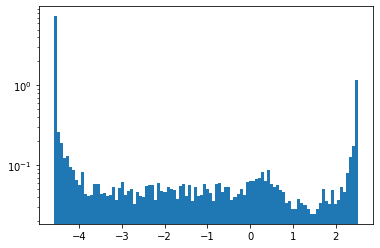

In [248]:
_ = plt.hist(logps, bins=100, density=True, log=True)

In [249]:
indices = np.argsort(logps)

In [250]:
print(indices)

[1367 4765 4754 ... 1756 5482 1943]


['default', 'classic', 'Solarize_Light2', '_classic_test_patch', 'bmh', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
-4.588927852877758
0.3045068


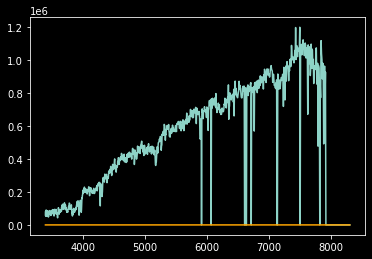

-4.588927852877758
0.3504975


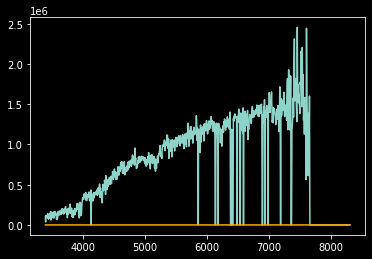

-4.588927852877758
0.33403504


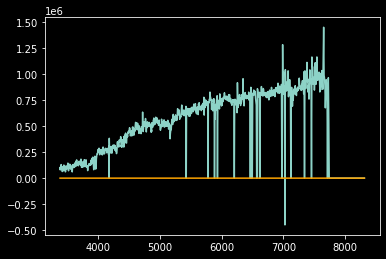

-4.588927852877758
0.3582187


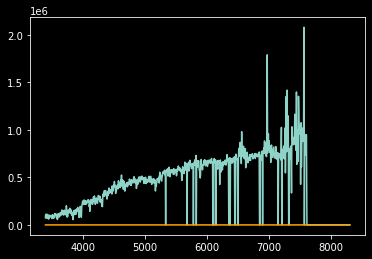

-4.588927852877758
0.29900068


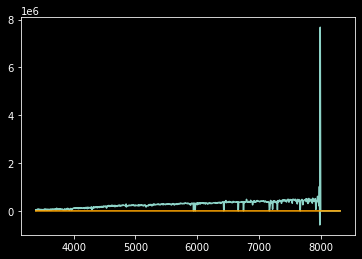

-4.588927852877758
0.32464573


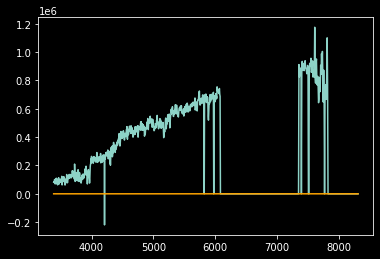

-4.588927852877758
0.3272632


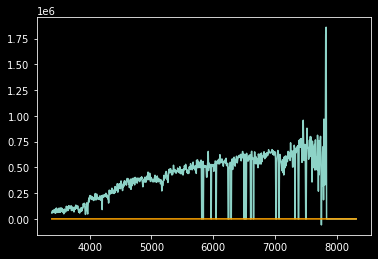

-4.588927852877758
0.31522152


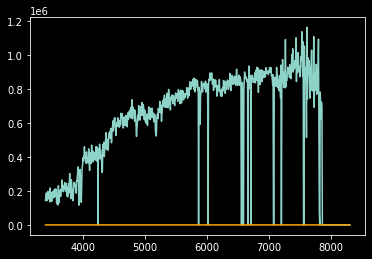

-4.588927852877758
0.35610974


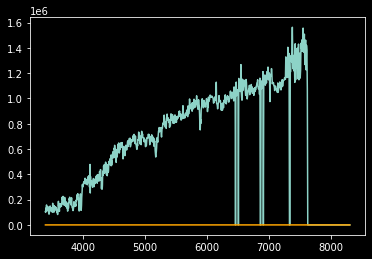

-4.588927852877758
0.35809493


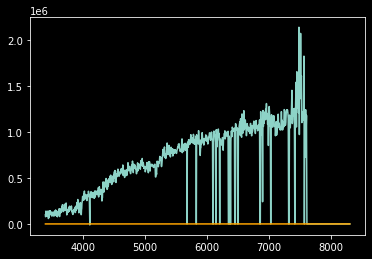

-4.588927852877758
0.34898818


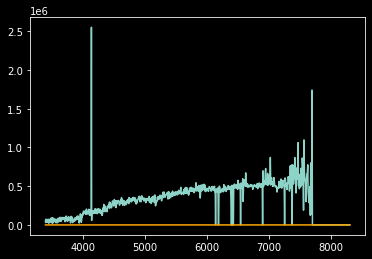

-4.588927852877758
0.32206208


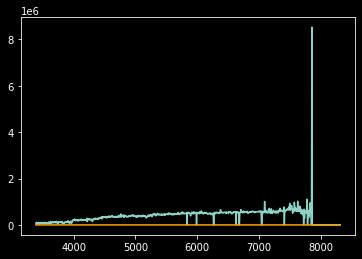

-4.588927852877758
0.34602126


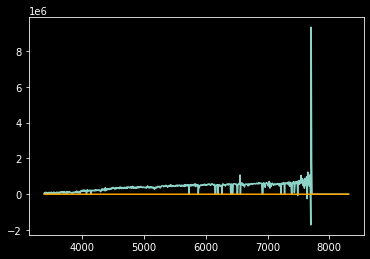

-4.588927852877758
0.31501427


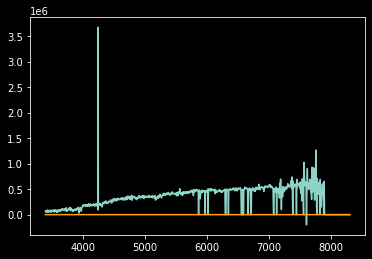

-4.588927852877758
0.35022655


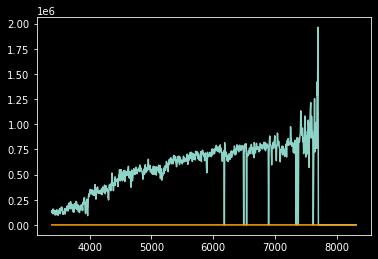

-4.588927852877758
0.3445745


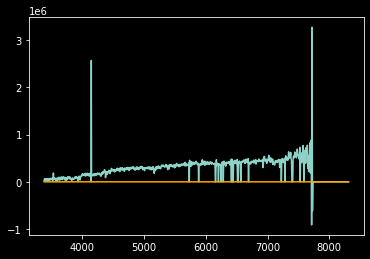

-4.588927852877758
0.33470142


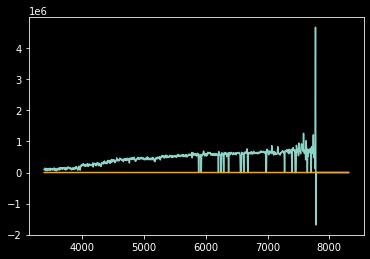

-4.588927852877758
0.32237792


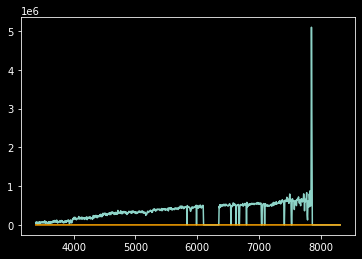

-4.588927852877758
0.35687268


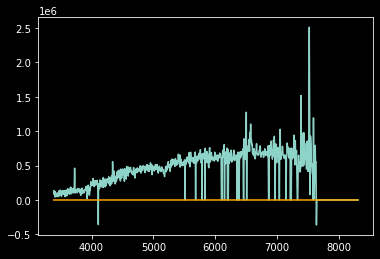

-4.588927852877758
0.25488898


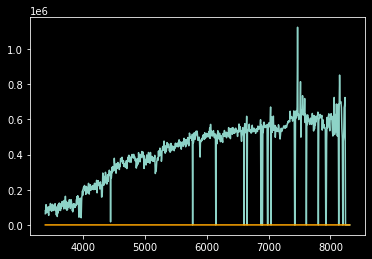

-4.588927852877758
0.3213898


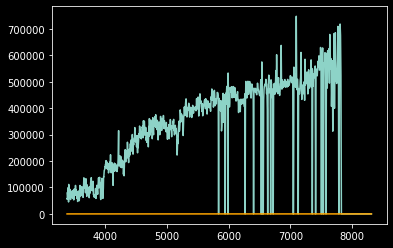

-4.588927852877758
0.35525122


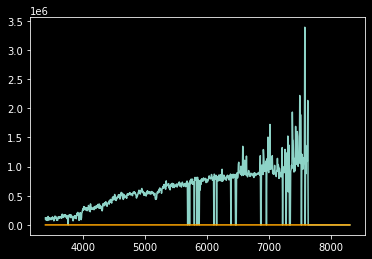

-4.588927852877758
0.30029935


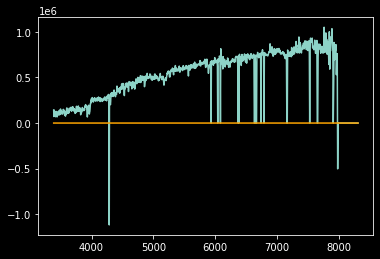

-4.588927852877758
0.3301932


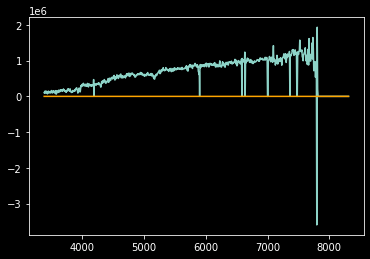

-4.588927852877758
0.34500247


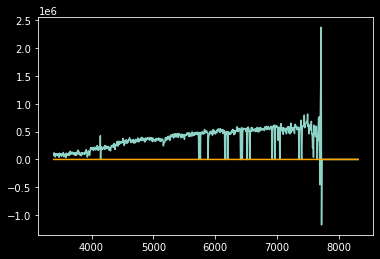

-4.588927852877758
0.33374587


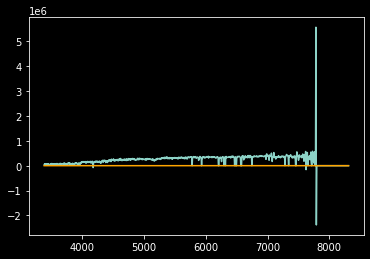

-4.588927852877758
0.34958938


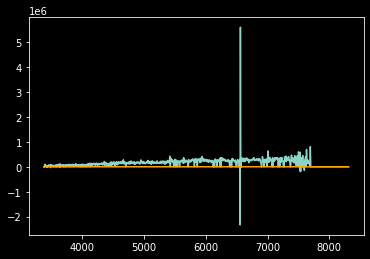

-4.588927852877758
0.32486728


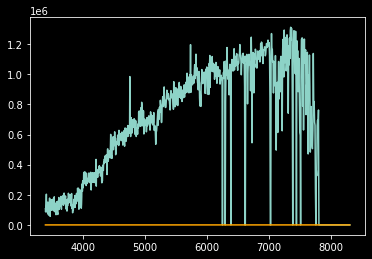

-4.588927852877758
0.3021055


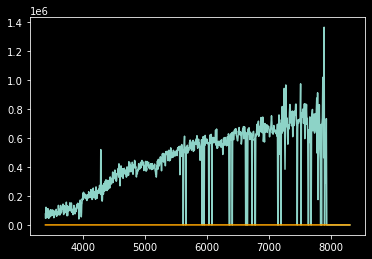

-4.588927852877758
0.30855563


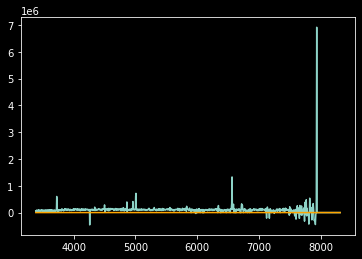

In [254]:

# style_list = ['default', 'classic'] + sorted(
#     style for style in plt.style.available if style != 'classic')
# print(style_list)
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            #fig = plot_figure(style_label=style_label)
            for ii in indices[0:30]:
                print(logps[ii])
                print(valid_params[ii])
                plt.plot(new_wl[:-1], np.squeeze(valid_data)[ii]*np.squeeze(valid_mask)[ii], )
                plt.plot(new_wl[:-1], np.squeeze(recon_train)[ii]*np.squeeze(valid_mask)[ii], color='orange')
                plt.show()

In [209]:
# encoded.shape

In [210]:
# decoder = extract_layers(lstm_ae, 18, -1)
# print(encoded.shape)

In [211]:
# decoder.predict(encoded).shape

In [212]:
    
plt.plot(np.mean((train_data[:512]-np.squeeze(recon_train[:512]))**2,axis=0))

ValueError: operands could not be broadcast together with shapes (512,1000,1) (512,1000) 

In [ ]:
plt.plot(np.std((valid_data[:512]-np.squeeze(recon_train[:512]))**2*np.squeeze(valid_noise)[:512]*np.asarray(masks)[:512],axis=0))

In [ ]:
plt.plot(np.std(np.squeeze(recon_train[:512])*np.asarray(masks)[:512],axis=0))

In [ ]:
plt.plot(np.std(np.squeeze(data[:512])*np.asarray(masks)[:512],axis=0))

In [ ]:

for ii in range(20):
    plt.plot(new_wl,data[ii]*masks[ii],label='noisy,masked truth')
    #errs = np.zeros(npix_max, np.int32)
    #errs[np.where(train[0][2][ii].numpy()!=0)[0]] = np.sqrt(1./(train[0][2][ii].numpy()[np.where(train[0][2][ii].numpy()!=0)]))
    plt.errorbar(new_wl,recon_train[ii]*masks[ii])#,yerr=np.squeeze(np.sqrt(1/train[0][3][ii])),label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
    plt.ylim(-0.1,0.1)
    #plt.xlim(4000,5000)
    plt.legend()
    plt.show()
#     plt.plot(np.arange(dim)[600:700],train[0][0][ii][600:700],label='noisy,masked truth')
#     plt.errorbar(np.arange(dim)[600:700],recon_train[ii][600:700],label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
#     plt.legend()
#     plt.show()

for ii in range(20):
    plt.plot(new_wl,(data[ii]-recon_train[ii])**2*noise_train[ii]*masks[ii])
    #errs = np.zeros(npix_max, np.int32)
    #errs[np.where(train[0][2][ii].numpy()!=0)[0]] = np.sqrt(1./(train[0][2][ii].numpy()[np.where(train[0][2][ii].numpy()!=0)]))
    #plt.errorbar(new_wl,*masks[ii])#,yerr=np.squeeze(np.sqrt(1/train[0][3][ii])),label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
    #plt.ylim(-0.1,0.1)
    #plt.xlim(4000,5000)
    plt.legend()
    plt.show()


In [ ]:
for test in test_dataset.take(1):
    for ii in range(20):
        plt.plot(test[0][0][ii],label='noisy,masked truth')
        errs = np.squeeze(np.sqrt(1/test[0][3][ii]))
        print(recon_test[ii].shape, errs.shape)
        plt.errorbar(np.arange(dim),np.squeeze(recon_test[ii]),yerr=errs,label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        plt.legend()
        plt.show()